# Capstone: Sentiment Analysis for Shopee
## Data Collection, Data Cleaning, Pre-processing and EDA
__Grace Chia__

---

## Problem Statement

Shopee is a fast-growing e-commerce platform in Southeast Asia. In order to build an enjoyable online shopping experience, Shopee's product managers would first need to identify customer sentiment and understand users' pain points.

As such, the data science team has been tasked to classify the positive and negative reviews on Shopee Singapore's Google Play using Natural Language Processing (NLP). The model that achieves the highest accuracy and recall on the validation set will be selected for production. The team will be using topic modeling to identify the key pain points among dissatisfied customers. This will enable product managers to address their immediate needs.

## Background

<img src="../images/ecommerce_market_size.png" width="400" align="left">

Source: Google, Temasek, Bain & Company e-Conomy SEA 2019

According to research done by [Google, Temasek and Bain](https://www.thinkwithgoogle.com/intl/en-apac/tools-resources/research-studies/e-conomy-sea-2019-swipe-up-and-to-the-right-southeast-asias-100-billion-internet-economy/), Singapore's e-commerce market was worthed US\\$2 billion in 2019, and is expected to grow 3.5 times to reach US\\$7 billion by 2025. High mobile penetration and fast internet connectivity, will be the key drivers of e-commerce growth. Furthermore, as consumers were encouraged to stay home as a result of COVID-19, many have started to grow accustomed to shopping online. This may just be the start of a new norm in consumer behaviour, where more start to shift from offline to online shopping.

While e-commerce presents huge opportunities, competition has been on the rise, with the key players being Lazada, Shopee and Qoo10. In efforts to build customer engagement and grow their share of wallet, competitors have improved the checkout experience, introduced gamification and overcame the challenges of last-mile delivery. Given stiff competition, it is crucial that Shopee continues to delight customers and address pain points in the online shopping experience. The sentiment analysis tool will enable Shopee's product managers to classify user sentiment accurately and understand the pain points.

## Methodology

**Data collection**:  
The scraping was done using [Google-Play-Scraper](https://github.com/JoMingyu/google-play-scraper) to collect users' reviews and ratings on Shopee's app. A total of 4,461 unique reviews were collected.

**Data cleaning**:
- Remove duplicated reviews
- Remove reviews that do not have any meaningful words
- Remove reviews that are non-English or gibberish

**Pre-processing**:
- Remove HTML tags
- Use regular expression to remove special characters and numbers
- Lowercase words
- Use NLTK to remove stopwords
- Remove frequently occurring words that appear in both positive and negative sentiments, like 'app', 'shopee', 'item', 'seller', 'bad'.
- Use NLTK to stem words to their root form

## Key Insights from EDA

**Time frame of the reviews written**  
The number of reviews for Shopee on Google Play has increased across all ratings (1-5 stars), between Jan and April 2020. This may likely be a result of the recent rise in e-commerce purchases. As the COVID-19 outbreak resulted in the forced closure of many brick-and-mortar stores during Singapore's circuit breaker period, many consumers started to turn to online shopping instead.

**Number of thumbs up received**  
Negative reviews with 1 or 2-star ratings receive more thumbs up on average, than positive reviews. This may suggest that several others face the same issues as those who have written these negative reviews.

**Number of meaningful words**  
The average number of meaningful words in a negative review (15 words) is higher than that in a positive review (7 words). There is also a noticeable higher variance in the number of meaningful words among negative reviews than positive reviews, suggesting that dissatisfied customers are more likely to write longer reviews. 

**Barplots: Top uni-grams and bi-grams**  
'Use', 'time' and 'order' are the top 3 most frequently occurring uni-grams in negative reviews. 'Customer service' is the top bi-gram seen among negative reviews. We can thus infer that users are somewhat dissatisfied with Shopee's customer service.   

'Good', 'shop' and 'easi' are the top 3 most frequently seen uni-grams in positive reviews. The bi-grams give us some context to the word 'easi', where it probably refers to an 'easy to use online shopping platform'.  

**VADER sentiment analysis**  
Given a compound score threshold of 0.175, VADER is able to correctly classify 80% of sentiments. As Shopee's product managers would also like to prioritise the identification of negative reviews so that they can fix immediate problems if necessary, achieving a decent recall rate is important. VADER is able to correctly classify 74% of actual negative reviews.

## Contents:
- [Import Libraries](#Import-Libraries)
- [Data Collection](#Data-Collection)
- [Data Cleaning & Pre-processing](#Data-Cleaning-&-Pre-processing)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)

## Import Libaries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Library to scrape Google Play
from google_play_scraper import Sort, reviews

from bs4 import BeautifulSoup
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
# from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

%matplotlib inline

## Data Collection

Users can rate [Shopee's app](https://play.google.com/store/apps/details?id=com.shopee.sg&hl=en_SG) on Google Play with a star rating and review. The ratings are on a 5-point scale, with 1 being the lowest score and 5 being the highest score one could possibly give. Since the goal of our project is to predict if a review has a positive or negative sentiment based on textual data, we will scrape real user reviews on Google Play.

[Google-Play-Scraper](https://github.com/JoMingyu/google-play-scraper) provides an API to crawl through Google Play. We used `pip install google-play-scraper` to install the package and scraped users' reviews and rating scores on Shopee's app.  

The reviews were collected in batches, according to their scores (1-5). This was done in an attempt to achieve a balanced dataset with roughly the same number of reviews for each score. Also, in order to gather reviews that had more text and were written recently, we set up the google play scraper to scrape from both review types, 'Most relevant' and 'Newest'.


In [3]:
# Commenting this out so that we don't re-run the cells and accidentally re-collect the data
# Create an empty list to store the reviews that we are about to collect
app_reviews = []

In [4]:
# Function to scrape reviews on google play store
# app: the url of the app we want to scrape
# score: number of stars rated by users
# n_loops: the number of loops to collect reviews in batches of 200

def reviews_scraper(app, score, n_loops):
    for sort_order in [Sort.MOST_RELEVANT, Sort.NEWEST]: # Collect both reviews types - 'most relevant' and 'newest'
        for i in range(n_loops):
            rvs, continuation_token = reviews(app,
                                              lang='en',
                                              country='sg',
                                              sort=sort_order,
                                              count=200, # 200 is the maximum number of reviews per page supported by Google Play
                                              filter_score_with=score,
                                              continuation_token=None if i==0 else continuation_token) # To begin crawling from where it last left off
            for r in rvs:
                r['sort_order'] = 'most_relevant' if sort_order == Sort.MOST_RELEVANT else 'newest'
                r['app_id'] = app
            app_reviews.extend(rvs)
            print('No. of reviews collected: ' + str(len(rvs)))

After setting up our scraping function, we will now collect the reviews in batches, based on their scores. As not many users left 2-3 star reviews on Shopee, hitting the site with more than 2 loops will return an error. Hence, `n_loops` for scores 2 and 3 star reviews were set to 2, rather than 5.

In [5]:
# Collect reviews that were rated 1 star
reviews_scraper(app='com.shopee.sg', score=1, n_loops=5)

No. of reviews collected: 200
No. of reviews collected: 200
No. of reviews collected: 200
No. of reviews collected: 200
No. of reviews collected: 200
No. of reviews collected: 200
No. of reviews collected: 200
No. of reviews collected: 200
No. of reviews collected: 200
No. of reviews collected: 200


In [6]:
# Collect reviews that were rated 2 stars
reviews_scraper(app='com.shopee.sg', score=2, n_loops=2)

No. of reviews collected: 200
No. of reviews collected: 200
No. of reviews collected: 200
No. of reviews collected: 200


In [7]:
# Collect reviews that were rated 3 stars
reviews_scraper(app='com.shopee.sg', score=3, n_loops=2)

No. of reviews collected: 200
No. of reviews collected: 200
No. of reviews collected: 200
No. of reviews collected: 200


In [8]:
# Collect reviews that were rated 4 stars
reviews_scraper(app='com.shopee.sg', score=4, n_loops=5)

No. of reviews collected: 200
No. of reviews collected: 200
No. of reviews collected: 200
No. of reviews collected: 200
No. of reviews collected: 200
No. of reviews collected: 200
No. of reviews collected: 200
No. of reviews collected: 200
No. of reviews collected: 200
No. of reviews collected: 200


In [9]:
# Collect reviews that were rated 5 stars
reviews_scraper(app='com.shopee.sg', score=5, n_loops=5)

No. of reviews collected: 200
No. of reviews collected: 200
No. of reviews collected: 200
No. of reviews collected: 200
No. of reviews collected: 200
No. of reviews collected: 200
No. of reviews collected: 200
No. of reviews collected: 200
No. of reviews collected: 200
No. of reviews collected: 200


In [10]:
# Save reviews to csv file
pd.DataFrame(app_reviews).to_csv('../data/shopee_reviews2.csv', index=False)

In [11]:
# Read in shopee csv file 
# Datetime parsing for 'at' and 'repliedAt' columns
reviews = pd.read_csv('../data/shopee_reviews2.csv', parse_dates=['at','repliedAt'])

In [12]:
# We have collected 7404 reviews 
reviews.shape

(7600, 13)

In [13]:
# View first 5 rows
reviews.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,sort_order,app_id
0,28103537-a7f2-4748-ab09-00eae61061ed,Rei Asuka,https://play-lh.googleusercontent.com/a/AGNmyx...,The app is workng fine. The issue i had was th...,1,332,2.91.31,2022-08-14 06:11:42,Thank you for bringing this issue to our atten...,2022-08-14 09:21:57,2.91.31,most_relevant,com.shopee.sg
1,89137ef2-561d-4f36-83b6-3b48cfaa8ac8,Alexander 1995,https://play-lh.googleusercontent.com/a/AGNmyx...,The issue of this rated 🌟 with genuine conside...,1,4,2.54.04,2020-08-13 20:37:40,Thank you for bringing this issue to our atten...,2020-08-13 22:16:39,2.54.04,most_relevant,com.shopee.sg
2,c9b45b86-2e35-4ab2-9b27-152881c4e4ff,Jaymes Chiang,https://play-lh.googleusercontent.com/a/AGNmyx...,Latest version of the app keeps crashing whene...,1,23,NaN,2022-03-02 00:10:18,NaN,NaT,NaN,most_relevant,com.shopee.sg
3,28430f95-0409-429c-ad10-e12a08be6c24,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,Be very careful when you use this platform. Ma...,1,9,2.23.31,2018-12-06 14:43:45,Hi Royis! We're so sorry for the unpleasant ex...,2018-12-06 22:16:34,2.23.31,most_relevant,com.shopee.sg
4,950deabd-3337-446f-8ca0-cae915fb9fbd,Starry Night,https://play-lh.googleusercontent.com/a-/ACB-R...,The app worked completely fine until one day I...,1,308,2.90.23,2022-07-22 22:39:16,Thank you for your review. We are sorry to hea...,2022-07-22 23:02:31,2.90.23,most_relevant,com.shopee.sg


In [14]:
# Check that the datatypes are correct eg. 'at' and 'repliedAt' are datetime
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7600 entries, 0 to 7599
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   reviewId              7600 non-null   object        
 1   userName              7600 non-null   object        
 2   userImage             7600 non-null   object        
 3   content               7600 non-null   object        
 4   score                 7600 non-null   int64         
 5   thumbsUpCount         7600 non-null   int64         
 6   reviewCreatedVersion  6948 non-null   object        
 7   at                    7600 non-null   datetime64[ns]
 8   replyContent          6474 non-null   object        
 9   repliedAt             6474 non-null   datetime64[ns]
 10  appVersion            6948 non-null   object        
 11  sort_order            7600 non-null   object        
 12  app_id                7600 non-null   object        
dtypes: datetime64[ns](

In [15]:
# Some null values in app version & developer replies
reviews.isnull().sum()

reviewId                   0
userName                   0
userImage                  0
content                    0
score                      0
thumbsUpCount              0
reviewCreatedVersion     652
at                         0
replyContent            1126
repliedAt               1126
appVersion               652
sort_order                 0
app_id                     0
dtype: int64

In [16]:
# Summary statistics for numerical variables
reviews.describe()

,score,thumbsUpCount,at,repliedAt
count,7600.000000,7600.000000,7600,6474
mean,3.157895,5.021579,2021-08-11 14:13:34.841315840,2021-09-17 23:43:58.531974144
min,1.000000,0.000000,2018-09-13 15:34:41,2018-09-13 16:35:05
25%,1.000000,0.000000,2020-08-07 08:50:48.750000128,2020-09-07 08:42:46
50%,4.000000,1.000000,2021-08-14 15:35:16.500000,2021-10-20 10:06:28
75%,5.000000,3.000000,2022-10-14 03:13:38.750000128,2022-11-11 08:10:59
max,5.000000,416.000000,2023-04-22 12:36:57,2023-04-22 13:38:14
std,1.564952,18.210625,NaN,NaN


In [17]:
# Check how many reviews were retrieved from each score
reviews['score'].value_counts().sort_index()

score
1    2000
2     800
3     800
4    2000
5    2000
Name: count, dtype: int64

## Data Dictionary

The data dictionary below provides an overview of the features in our dataset.

| Feature              | Type     | Description                                                                                        |
|:----------------------|:----------|:----------------------------------------------------------------------------------------------------|
| reviewId             | obj      | Unique review Id                                                                                   |
| userName             | obj      | Username of the reviewer                                                                           |
| userImage            | obj      | Url link to the user's profile photo                                                                         |
| content              | obj      | Textual data of the review                                                                         |
| score                | int      | No. of star ratings the user gave (1-5)                                                                  |
| thumbsUpCount        | int      | No. of thumbs up the review received from other users                                              |
| reviewCreatedVersion | obj      | App version                                                                                        |
| at                   | datetime | Date and time of which the review was written                                                      |
| replyContent         | obj      | Shopee's reply to the review                                                                       |
| repliedAt            | datetime | Date and time of Shopee's reply                                                                    |
| sort_order           | obj      | Indicates whether the data was scraped from the 'Most relevant' or 'Newest' section in Google Play |
| app_id               | obj      | The url which the reviews were collected from                                                      |

## Data Cleaning & Pre-processing

### Remove duplicated reviews

As we have scraped reviews that were sorted by 'Most relevant' and 'Newest', there will definitely be duplicates in our dataset. We will be dropping these duplicates to ensure that we train and test our model on unique reviews.

In [18]:
# 7404 reviews in our dataframe
reviews.shape

(7600, 13)

In [19]:
# There are 2943 duplicates
reviews[reviews.duplicated(['userName', 'content', 'at'])].shape

(3800, 13)

In [20]:
# Drop duplicates as we only want unique reviews
reviews.drop_duplicates(['userName', 'content', 'at'], inplace=True)

In [21]:
# Reindex the dataframe
reviews.reset_index(drop=True, inplace=True)

In [22]:
# Check that we have dropped these duplicates
reviews.shape

(3800, 13)

In [23]:
# Check how many reviews we have for each score after dropping the duplicates
reviews['score'].value_counts().sort_index()

score
1    1000
2     400
3     400
4    1000
5    1000
Name: count, dtype: int64

### Rename columns

It is good practice to use snake case when naming our columns.

In [24]:
# Rename the columns to lowercase and use underscores
reviews.rename(columns={'reviewId': 'review_id', 
                        'userName': 'username', 
                        'userImage': 'user_image', 
                        'thumbsUpCount': 'thumbs_up_count', 
                        'reviewCreatedVersion': 'review_created_version', 
                        'replyContent': 'reply_content',
                        'repliedAt': 'replied_at'},
              inplace=True)

In [25]:
# Check that columns have been correctly renamed
reviews.columns

Index(['review_id', 'username', 'user_image', 'content', 'score',
       'thumbs_up_count', 'review_created_version', 'at', 'reply_content',
       'replied_at', 'appVersion', 'sort_order', 'app_id'],
      dtype='object')

### Create a target variable

The goal is to classify positive and negative app reviews. Negative reviews can reveal critical features that are missing from Shopee's app or even bring to light the presence of bugs on the app. This will require immediate action from Shopee. As such, priority will be placed on the prediction of negative sentiment. We will assign the negative reviews (scores 1-3) to class 1, and the positive reviews (scores 4-5) to class 0.

In [26]:
# Defining the target variable using scores
reviews['target'] = reviews['score'].map(lambda x: 1 if x < 4 else 0)

In [27]:
# Check the count of our target variable
reviews['target'].value_counts()

target
0    2000
1    1800
Name: count, dtype: int64

In [28]:
# Check that the target variable has been added to our dataframe
reviews.head()

,review_id,username,user_image,content,score,thumbs_up_count,review_created_version,at,reply_content,replied_at,appVersion,sort_order,app_id,target
0,28103537-a7f2-4748-ab09-00eae61061ed,Rei Asuka,https://play-lh.googleusercontent.com/a/AGNmyx...,The app is workng fine. The issue i had was th...,1,332,2.91.31,2022-08-14 06:11:42,Thank you for bringing this issue to our atten...,2022-08-14 09:21:57,2.91.31,most_relevant,com.shopee.sg,1
1,89137ef2-561d-4f36-83b6-3b48cfaa8ac8,Alexander 1995,https://play-lh.googleusercontent.com/a/AGNmyx...,The issue of this rated 🌟 with genuine conside...,1,4,2.54.04,2020-08-13 20:37:40,Thank you for bringing this issue to our atten...,2020-08-13 22:16:39,2.54.04,most_relevant,com.shopee.sg,1
2,c9b45b86-2e35-4ab2-9b27-152881c4e4ff,Jaymes Chiang,https://play-lh.googleusercontent.com/a/AGNmyx...,Latest version of the app keeps crashing whene...,1,23,NaN,2022-03-02 00:10:18,NaN,NaT,NaN,most_relevant,com.shopee.sg,1
3,28430f95-0409-429c-ad10-e12a08be6c24,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,Be very careful when you use this platform. Ma...,1,9,2.23.31,2018-12-06 14:43:45,Hi Royis! We're so sorry for the unpleasant ex...,2018-12-06 22:16:34,2.23.31,most_relevant,com.shopee.sg,1
4,950deabd-3337-446f-8ca0-cae915fb9fbd,Starry Night,https://play-lh.googleusercontent.com/a-/ACB-R...,The app worked completely fine until one day I...,1,308,2.90.23,2022-07-22 22:39:16,Thank you for your review. We are sorry to hea...,2022-07-22 23:02:31,2.90.23,most_relevant,com.shopee.sg,1


### Pre-processing

Next, we will perform pre-processing to transform our text into a more digestible form for our classifier. The steps are as follows:
- Remove HTML tags
- Use regular expression to remove special characters and numbers
- Lowercase words
- Use NLTK to remove stopwords
- Remove frequently occurring words that appear in both positive and negative sentiments, like 'app', 'shopee', 'item', 'seller', 'bad'. Removing these words led to a 1 and 2 percentage point improvement in our model's accuracy and recall rate, respectively.
- Use NLTK to stem words to their root form. Note that the model returned better accuracy when we used stemming, rather than lemmatizing.

It is also good to note that we have tried using SpaCy to remove stopwords and for lemmatizing. However, our model's performance was much better when the text was pre-processed using NLTK.

In [29]:
# Write a function to convert raw text to a string of meaningful words
def stem_text(raw_text):
  
    # Remove HTML tags
    review_text = BeautifulSoup(raw_text).get_text()
    
    # Remove non-letters
    letters_only = re.sub("[^a-zA-Z]", " ", review_text)
    
    # Convert words to lower case and split each word up
    words = letters_only.lower().split()
    
    # Searching through a set is faster than searching through a list 
    # Hence, we will convert stopwords to a set
    stops = set(stopwords.words('english'))
    
    # Adding on stopwords that were appearing frequently in both positive and negative reviews 
    stops.update(['app','shopee','shoppee','item','items','seller','sellers','bad']) 
    
    # Remove stopwords
    meaningful_words = [w for w in words if w not in stops]
        
    # Instantiate PorterStemmer
    p_stemmer = PorterStemmer()
    
    # Stem words
    meaningful_words = [p_stemmer.stem(w) for w in meaningful_words]        
   
    # Join words back into one string, with a space in between each word
    return(" ".join(meaningful_words))

In [30]:
# Pre-process the raw text
reviews['content_stem'] = reviews['content'].map(stem_text)

C:\Users\steam\AppData\Local\Temp\ipykernel_21408\2471120977.py:5: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  review_text = BeautifulSoup(raw_text).get_text()


Let us compare our original text with the pre-processed version.

In [31]:
# This is the original text of the first review in our dataset
reviews.loc[0]['content']

"The app is workng fine. The issue i had was the shopee pet game. 1) Half the time, it will get stuck at 99% loading. 2) 20% of the time, it will not be able to connect to server after you completeed the music minigame and have to replay the minigame again. 3) Worst of all is the soccer minigame. Even if the goalie is at one end of the goal, it can still block the ball at the other end, making it totally based on luck. Sometimes, it doesn't even need to touch the ball to block it."

In [32]:
# This is how the text looks like after stemming
reviews.loc[0]['content_stem']

'workng fine issu pet game half time get stuck load time abl connect server complete music minigam replay minigam worst soccer minigam even goali one end goal still block ball end make total base luck sometim even need touch ball block'

### Remove reviews that do not have any meaningful words

After pre-processing, we notice that there are some reviews that do not have any meaningful words left. As these reviews largely consists of only emojis or Chinese characters, these reviews returned blank fields after stemming. In other words, the length of these reviews after pre-processing, was 0. Given that these reviews will not add value to our model's training, we will remove them from our dataset. 

In [33]:
# Find the number of meaningful words in each review
reviews['content_clean_len'] = reviews['content_stem'].str.split().map(len)

In [34]:
# There are 48 reviews that do not have any meaningful words
reviews[reviews['content_clean_len']==0].shape

(0, 16)

In [35]:
# View reviews that do not have any meaningful words
reviews[reviews['content_clean_len']==0]['content']

Series([], Name: content, dtype: object)

In [36]:
# Drop these reviews that do not have any meaningful words
reviews = reviews.drop(reviews[reviews['content_clean_len']==0].index)

In [37]:
# Reindex the dataframe
reviews.reset_index(drop=True, inplace=True)

### Remove reviews that are non-English or gibberish

We have identified several reviews that were written in non-English or simply gibberish. As we would like to train and test our model with only English text, we will remove these reviews to reduce the noise in our dataset.

In [38]:
# # Index of reviews to drop
# reviews_to_drop = [760,791,815,822,833,835,842,843,846,847,849,852,853,
#                    854,855,857,887,1000,1003,1011,1012,1018,1019,1020,1021,
#                    1022,1032,1036,1039,1211,1218,1221,1334,1336,1342,1343,1347,
#                    1348,1351,1600,1601,1604,1609,1611,1637,1664,1708,1730,1737,
#                    2520,2566,2589,2626,2627,2733,3831,3864,3866,3901,3986,4044,
#                    4203,4262,4279,4365]

In [39]:
# # There are 65 non-English or gibberish reviews
# len(reviews_to_drop)

65

In [40]:
# # View all the reviews that are non-English or gibberish
# reviews.loc[reviews_to_drop,'content']

KeyError: '[3831, 3864, 3866, 3901, 3986, 4044, 4203, 4262, 4279, 4365] not in index'

In [ ]:
# # Check shape of dataframe before dropping
# reviews.shape

(4413, 15)

In [ ]:
# # Drop these reviews
# reviews.drop(reviews_to_drop, inplace=True)

In [ ]:
# # Check that these reviews have been dropeed
# reviews.shape

(4348, 15)

### Create a train and test set

20% of the original dataset will be set aside and used as a test set. This will be useful in evaluating our model's performance on unseen data.  

We will use stratify to preserve the class representation in our train and test set.

In [41]:
# As we would like to stratify our target variable, we will need to first assign X and y
X = reviews[[cols for cols in reviews.columns if cols != 'target']]
y = reviews['target']

In [42]:
# Perform a train_test_split to create a train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [43]:
# Merge X_train and y_train back together using index
train = pd.merge(X_train, y_train, left_index=True, right_index=True)

# Merge X_test and y_test back together using index
test = pd.merge(X_test, y_test, left_index=True, right_index=True)

In [44]:
train

,review_id,username,user_image,content,score,thumbs_up_count,review_created_version,at,reply_content,replied_at,appVersion,sort_order,app_id,content_stem,content_clean_len,target
3331,db89c9fb-e2ed-417c-8cb0-00cfb8504721,Chung Yuen Wong,https://play-lh.googleusercontent.com/a/AGNmyx...,Good platform. Like that it will ensure produc...,5,0,2.95.33,2022-11-08 15:25:27,Thank you for giving Shopee a 5-star review! W...,2022-11-08 16:07:22,2.95.33,most_relevant,com.shopee.sg,good platform like ensur product well receiv r...,12,0
3534,589eaec6-47cb-4fcd-84d3-ee8122d9574b,Josephine Chua,https://play-lh.googleusercontent.com/a-/ACB-R...,"My first experience, excited and joyful as i g...",5,0,2.79.21,2021-11-18 19:51:22,Thank you for giving Shopee a 5-star review! W...,2021-11-18 21:51:18,2.79.21,most_relevant,com.shopee.sg,first experi excit joy get buy thing without t...,19,0
2647,784c5d53-a064-4d01-81d0-59fb2283af2e,Jocelyn Goh,https://play-lh.googleusercontent.com/a/AGNmyx...,Good wide variety of goods. Enjoy shopping wit...,4,0,2.89.41,2022-07-06 07:32:53,Thank you for your review. We're excited to be...,2022-07-06 08:26:07,2.89.41,most_relevant,com.shopee.sg,good wide varieti good enjoy shop keep hope be...,12,0
265,45d9fc75-8399-4850-a01b-e86b6440fa87,Zc0ol,https://play-lh.googleusercontent.com/a/AGNmyx...,Dishonest facebook marketing brought me here. ...,1,1,NaN,2021-01-22 11:58:01,Thank you for bringing this issue to our atten...,2021-01-22 12:58:08,NaN,most_relevant,com.shopee.sg,dishonest facebook market brought spam ad chea...,40,1
1583,827451b3-cb68-419b-92f6-f3cc8457d669,Jeremy C,https://play-lh.googleusercontent.com/a/AGNmyx...,"Convenient and easy to use, however coupons ha...",3,1,2.82.21,2022-12-16 20:16:36,Thank you for bringing this issue to our atten...,2022-12-17 13:35:18,2.82.21,most_relevant,com.shopee.sg,conveni easi use howev coupon extrem strict cr...,16,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3542,b6159866-24ca-4af2-9d2e-c47dd676feb8,Siew Yin,https://play-lh.googleusercontent.com/a/AGNmyx...,Use to be a regular and happy customer of Laza...,5,5,2.74.15,2021-07-27 17:11:32,Thank you for giving Shopee a 5-star review! W...,2021-07-27 18:16:15,2.74.15,most_relevant,com.shopee.sg,use regular happi custom lazada past tri month...,37,0
733,cfc7245a-cee9-472a-8489-ab23ed9f3c56,Corneles Jaemes,https://play-lh.googleusercontent.com/a/AGNmyx...,"App takes ages to load and if it does load, do...",1,0,NaN,2021-06-10 08:26:51,Thank you for bringing this issue to our atten...,2021-06-10 17:23:08,NaN,most_relevant,com.shopee.sg,take age load load load properli mani icon mis...,18,1
3584,7667ff25-f8e6-4008-9569-0e26b622424a,Sarina Banu,https://play-lh.googleusercontent.com/a-/ACB-R...,A trustable app for most of my shopping needs....,5,9,2.68.11,2021-03-24 19:52:57,NaN,NaT,2.68.11,most_relevant,com.shopee.sg,trustabl shop need beauti product mobil cover ...,22,0
2399,beb580c8-96ac-460e-84ec-7339a312e90a,Su Thwe,https://play-lh.googleusercontent.com/a-/ACB-R...,Do you guys know your app is down? It's showin...,4,0,2.70.08,2021-04-28 01:07:14,Thank you for your review. We're excited to be...,2021-04-28 01:58:10,2.70.08,most_relevant,com.shopee.sg,guy know show internet connect wherev click th...,19,0


In [45]:
# Reindex the train and test set
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

In [46]:
# 3478 documents in our training set
train.shape

(3040, 16)

In [47]:
# 870 documents in our test set
test.shape

(760, 16)

In [48]:
# Check split in class labels for training set
train['target'].value_counts(normalize=True)

target
0    0.526316
1    0.473684
Name: proportion, dtype: float64

In [49]:
# Check split in class labels for test set
test['target'].value_counts(normalize=True)

target
0    0.526316
1    0.473684
Name: proportion, dtype: float64

Finally, after data cleaning, we now have 3478 reviews for training and 870 reviews in our test set. The class representation is consistent across the train and test set, with 61% of the data belonging to class 0 (positive sentiment) and 39% belonging to class 1 (negative sentiment).

## Exploratory Data Analysis

We will perform EDA to draw insights from our training set. This step is also crucial in helping us determine if any more pre-processing is necessary before training the model.

### Time frame of the reviews written

We will compare the distributions of the review dates across various ratings, 1-5.

In [50]:
# Create histogram subplots for each rating (1-5)
# Each subplot represents the distribution of the dates at which the reviews were written
def subplot_histograms(main_title, list_of_titles, xlabels, list_of_colors):
    fig, ax = plt.subplots(5, 1, figsize=(8,10), sharex=True, sharey=True)
    for i in range(5):
        ax[i].hist(train[train['score']==(i+1)]['at'], bins=50, color=list_of_colors[i])
        ax[i].set_title(list_of_titles[i], weight='bold')
        ax[i].set_xlabel(xlabels)
        ax[i].set_ylabel('Frequency')
    fig.suptitle(main_title, fontsize=15, weight='bold')
    fig.tight_layout()
    fig.subplots_adjust(top=0.9)

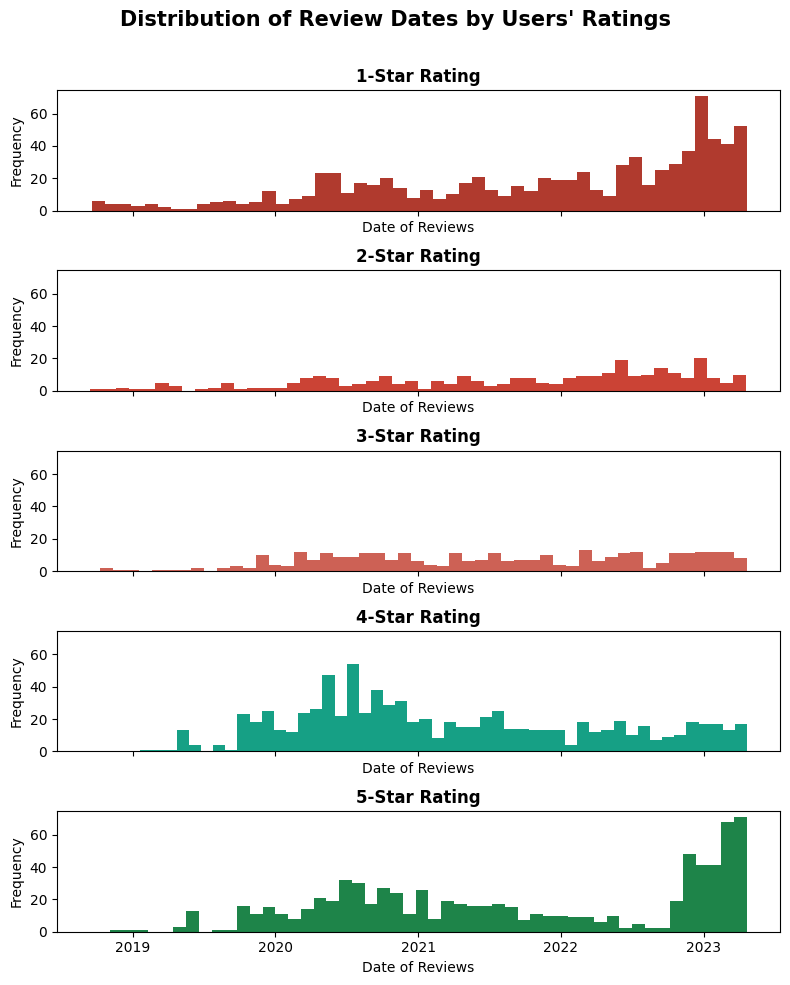

In [51]:
subplot_histograms(main_title="Distribution of Review Dates by Users' Ratings",
                   list_of_titles=['1-Star Rating','2-Star Rating','3-Star Rating','4-Star Rating','5-Star Rating'], 
                   xlabels='Date of Reviews',
                   list_of_colors = ['#B03A2E','#CB4335','#CD6155','#16A085','#1E8449'])

The distributions of review dates differ greatly across various rating scores. While the data collected for 5-star ratings are all dated in the year 2020, some of the 2-star and 3-star reviews are dated back to 2015. In an ideal world, we would like the reviews for each rating score to be collected in equal quantities, over the same time period. However, given that there were not many users that gave a 1-3 score, the data collection for negative reviews had to go back further in time. This was to obtain a balanced class training set, consisting of a relatively equal split between positive and negative reviews.  

A key observation here is that the number of reviews for Shopee on Google Play has increased across all ratings, between Jan and April 2020. This may likely be a result of the recent **rise in e-commerce purchases**. As the COVID-19 outbreak resulted in the forced closure of many brick-and-mortar stores during Singapore's circuit breaker period, many consumers started to turn to online shopping instead.

> According to the Singapore Department of Statistics, e-commerce sales made up 8.5% of total retail takings in March, an increase from 5.8% in January and 7.4% in February.

In [52]:
# 10 reviews written in the context of 'circuit breaker'
len(train[train['content'].str.contains('circuit')])

6

In [53]:
pd.set_option('display.max_colwidth', None)

# Reviews that mentioned the word 'circuit'
train[train['content'].str.contains('circuit')][['content','score']]

,content,score
2089,Spent most of the circuit breaker on this online shopping platform. My favorite hobby now.,4
2486,Downloaded this app during circuit breaker to buy some necessary equipment. It has been a great experience so far and the occasional games are pretty entertaining. The flash deals have some value for money deals sometimes which is a good feature. Recommended app.,5
2651,Wide range of products and good prices mostly. Surprised by quick delivery by some sellers during the circuit breaker.,4
2729,Product received as per described but could be better if shipment was faster...hopefully only during circuit breaker period only.,4
2737,"1-extremely laggy during the circuit breaker period. but very wide choices. some shops are not well organised and some don't even reply. understand it is not your fault. but still glad to have such a platform like shopee. 2-can feedback to IT can add a ""save"" rating? my rating gone because app lag too much. 3- ninja van does not inform before delivery. I had to wait whole day at home and at times the things didn't turn up. had feedback to them as well and hope shopee can assist too.",3
2789,Good experience! Have been shopping more during circuit breaker period. Playing games and collecting some coins to deduct off purchase. Fun! I enjoyed using Shopee a lot. I can find literally everything I want or need from Shopee at cheaper and reasonable price! Thumbs up!,5


### Number of thumbs up received

Users can show their approval by giving a "thumbs up" to reviews on Shopee's app. A higher number of thumbs up received from the community will suggest that several others have also been experiencing the same issues.

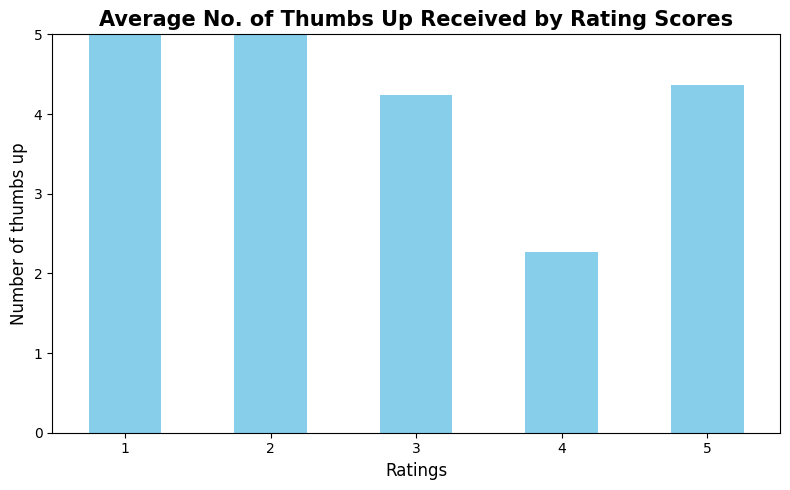

In [54]:
# Group by rating scores and find the average no. of thumbs up per score
train.groupby('score')['thumbs_up_count'].mean().plot(kind='bar', figsize=(8,5), color='skyblue')
plt.xlabel('Ratings', fontsize=12)
plt.xticks(rotation=0)
plt.ylabel('Number of thumbs up', fontsize=12)
plt.ylim(0,5)
plt.title('Average No. of Thumbs Up Received by Rating Scores', fontsize=15, weight='bold')
plt.tight_layout();

Negative reviews with 1 or 2-star ratings receive more thumbs up on average, than positive reviews.

In [55]:
# Show the top 5 reviews that received the highest number of thumbs up
train[['content','thumbs_up_count','score']].sort_values(by='thumbs_up_count', ascending=False).head()

,content,thumbs_up_count,score
2179,"I don't know what's happening with the app right now. Used to be just fine and easy to access your cart, use your vouchers and etc. Now I'm unable to go to cart, use/claim vouchers, to view the flash deal even..it has been happening for the past few days. It kept prompting 'Oops, something went wrong. We are looking into it.' how long has it been and it's still the same. I've uninstall and reinstall app still same issue. Updated the app but still same issue.",416,2
95,"The app is workng fine. The issue i had was the shopee pet game. 1) Half the time, it will get stuck at 99% loading. 2) 20% of the time, it will not be able to connect to server after you completeed the music minigame and have to replay the minigame again. 3) Worst of all is the soccer minigame. Even if the goalie is at one end of the goal, it can still block the ball at the other end, making it totally based on luck. Sometimes, it doesn't even need to touch the ball to block it.",332,1
58,"Vouchers are all restricted to shopeepay only. The platform went from great to terrible. Not to mention, now they are charging shipping fee on everything. It used to be free or if you want it to be fast you pay extra for it which was reasonable. Now I pay for all shipment fees yet the sellers ship them out the very last minute??? And now the standard fee is $1, not even a few months ago it was 0.60¢ for standard, and $1 express PER VENDOR.",316,1
1207,"The app worked completely fine until one day I couldn't see my cart, my vouchers, my coins, or even check on my items that are currently shipping. I keep getting the same error message saying that there was a problem/error with the server. I've been using the app for quite some time and I am very dissapointed in the lack of fixing done to the app (the website works fine in my experience).",308,1
1972,"I have been using Shopee for a long time but recently there are a lot of issues. My hp burns when I use the app (no issues while using any other apps), I cannot view lives (the screen is just blank) and I keep encountering error messages. I uninstalled and installed the app and it would be working fine until the issues come back again in 1-2 days time. I have uninstalled and installed the app for a couple of times now and its getting on my nerves.",287,1


### Number of meaningful words

We will compare the length of the reviews among positive vs negative sentiments.

C:\Users\steam\AppData\Local\Temp\ipykernel_21408\485066069.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(neg_len, color='red', ax=ax[0])
C:\Users\steam\AppData\Local\Temp\ipykernel_21408\485066069.py:18: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pos_len, color='green', ax=ax[1])


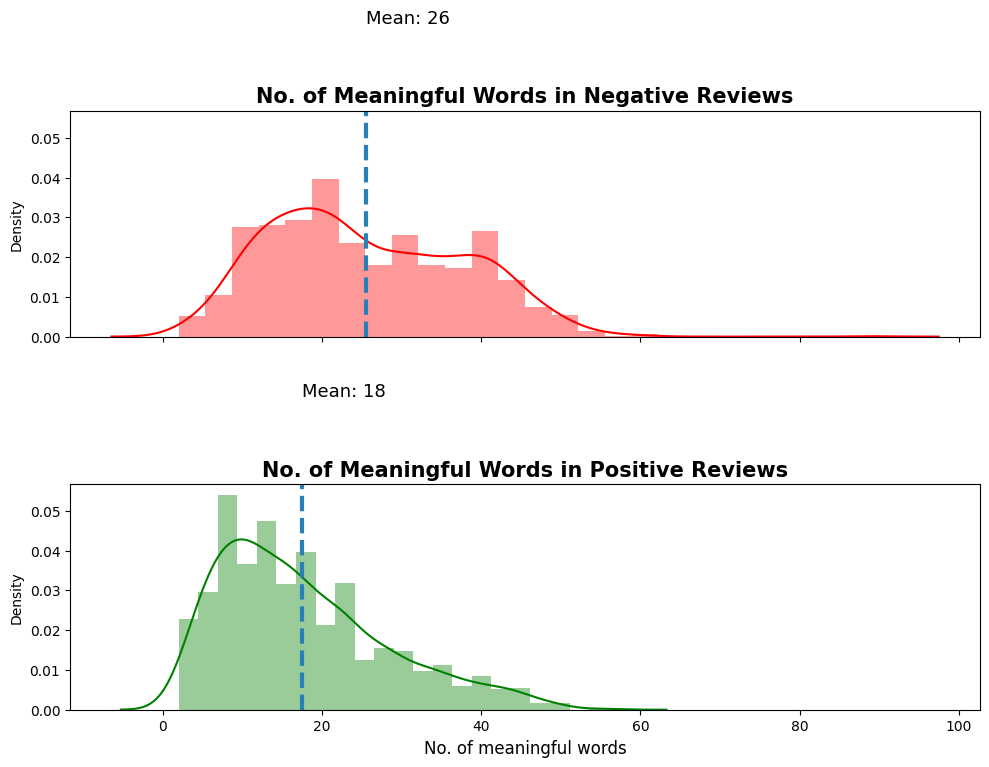

In [56]:
fig, ax = plt.subplots(2, 1, figsize=(10,8), sharex=True, sharey=True)

# Plots the distribution of the length of negative reviews
neg_len = train[train['target']==1]['content_clean_len']
sns.distplot(neg_len, color='red', ax=ax[0])
ax[0].axvline(neg_len.mean(), linestyle='dashed', linewidth=3, c='#2980B9') # Plot the mean line
ax[0].text(x=neg_len.mean(),
           y=0.08,
           s=f'Mean: {round(neg_len.mean())}', 
           horizontalalignment='left', 
           verticalalignment='center',
           fontsize=13)
ax[0].set_title('No. of Meaningful Words in Negative Reviews', fontsize=15, fontweight='bold')
ax[0].set_xlabel('No. of meaningful words', size=12)

# Plots the distribution of the length of positive reviews
pos_len = train[train['target']==0]['content_clean_len']
sns.distplot(pos_len, color='green', ax=ax[1])
ax[1].axvline(pos_len.mean(), linestyle='dashed', linewidth=3, c='#2980B9') # Plot the mean line
ax[1].text(x=pos_len.mean(),
           y=0.08,
           s=f'Mean: {round(pos_len.mean())}', 
           horizontalalignment='left', 
           verticalalignment='center',
           fontsize=13)
ax[1].set_title('No. of Meaningful Words in Positive Reviews', fontsize=15, fontweight='bold')
ax[1].set_xlabel('No. of meaningful words', size=12)
plt.tight_layout();

Both distributions are right-skewed, with only a small proportion of posts that have >40 meaningful words. In fact, only 0.6% of positive reviews and 6% of positive reviews have more than 40 meaningful words. The average number of meaningful words in a negative review (15 words) is higher than that in a positive review (7 words). There is also a noticeable higher variance in the number of meaningful words among negative reviews than positive reviews, suggesting that dissatisfied customers are more likely to write longer reviews.

In [57]:
# Number of reviews that had >40 meaningful words
train[train['content_clean_len']>40]['target'].value_counts().sort_index()

target
0     65
1    203
Name: count, dtype: int64

In [58]:
train['target'].value_counts()

target
0    1600
1    1440
Name: count, dtype: int64

In [59]:
# Only 0.6% of positive reviews have > 40 meaningful words
72/1600

0.045

In [60]:
# 6% negative reviews have > 40 meaningful words
201/1440

0.13958333333333334

### Wordclouds: Most frequently used words

Word clouds are useful in visualising some of the most frequently occurring words in positive and negative reviews.

In [61]:
# Write a function to plot a wordcloud of the most frequently occurring words

def plot_wordcloud(target, title):
    
    # Clean text that we want to wordcloud. Target will be class 1 (negative reviews) or class 0 (positive reviews)
    text = train[train['target']==target]['content_stem'] 

    wordcloud = WordCloud(width=2000, 
                          height=1000, 
                          background_color='white', 
                          max_words=50, # Maximum no. of words in the wordcloud
                          stopwords=STOPWORDS).generate(' '.join(text)) # Remove stopwords
    
    plt.figure(figsize=(10,8))
    plt.title(title, fontsize=15, weight='bold')
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off') # Removes the axis
    plt.tight_layout()

In [62]:
# Wordcloud of the 50 most frequently occurring words among negative reviews
plot_wordcloud(target=1, title='Most Frequently Used Words among Negative Reviews (Ratings 1-3)')

NameError: name 'WordCloud' is not defined

The words 'use' and 'order' are the most frequently seen words among reviews with negative sentiment.

In [63]:
# Wordcloud of the 50 most frequently occurring words among positive reviews
plot_wordcloud(target=0, title='Most Frequently Used Words among Positive Reviews (Ratings 4-5)')

NameError: name 'WordCloud' is not defined

On the other hand, words like 'good', 'great' and 'product' are the top words seen in reviews associated with positive sentiment.

### Barplots: Top uni-grams and bi-grams

We will use CountVectorizer to tokenize our textual data and generate bar plots for the top uni-grams and bi-grams seen in each sentiment. Are there unique words that will help us to distinguish between positive and negative sentiments? Or, are there certain words that are occurring in both sentiments?

In [64]:
# Plots top 20 uni-grams and bi-grams for positive and negative reviews

def barplot_cvec(target, titles, color, xlimit):
    
    words_series = train[train['target']==target]['content_stem']
    
    fig, ax = plt.subplots(1, 2, figsize=(25,12))
    
    ngram = [(1,1),(2,2)] # The ngrams that we would like to plot
    
    for i in range(2):
            
        # Use CountVectorizer to tokenize the text, 
        cvec = CountVectorizer(stop_words='english', ngram_range=ngram[i])

        # Save the tokens in a dataframe
        cvec_df = pd.DataFrame(cvec.fit_transform(words_series).todense(), columns=cvec.get_feature_names_out())
        sum_words = cvec_df.sum(axis=0) # Sum up the no. of occurences for each word
        top_words = sum_words.sort_values(ascending=False).head(20)
        top_words.sort_values(ascending=True).plot(kind='barh', color=color, ax=ax[i])

        # Adjust plot aesthetics
        ax[i].set_title(titles[i], size=25, weight='bold')
        ax[i].set_xlabel('Count', size=20)
        ax[i].set_xlim(xlimit) # Setting a limit so that the barplots are comparable
        ax[i].tick_params(axis='both', which='major', labelsize=20)
        ax[i].tick_params(axis='both', which='minor', labelsize=20)

    plt.tight_layout()

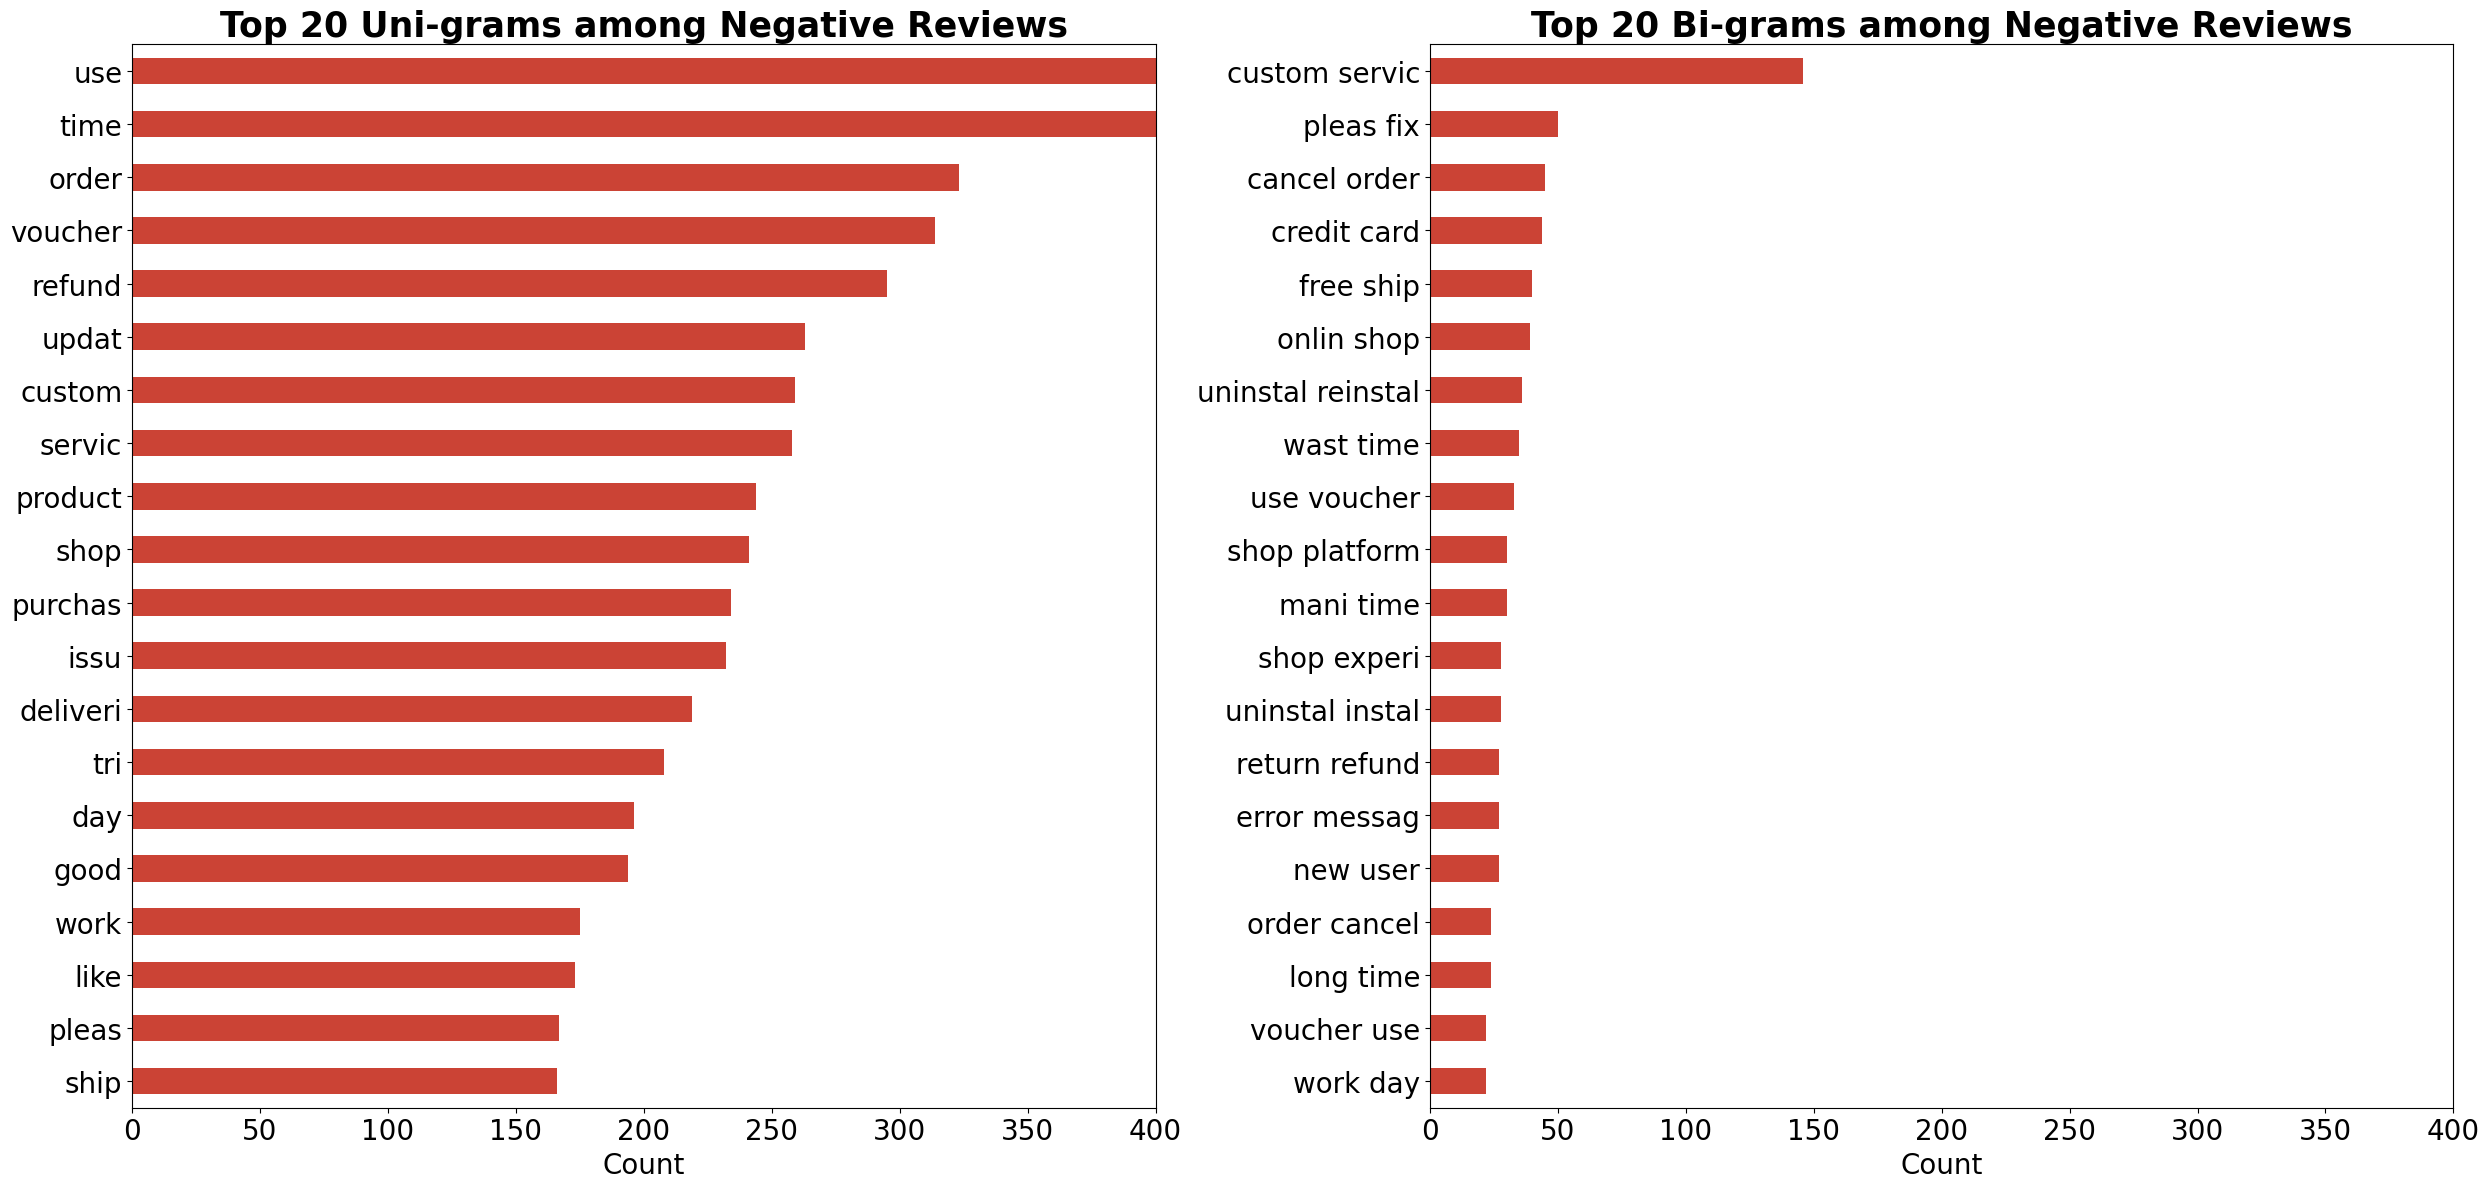

In [65]:
# Plot the uni-grams and bi-grams for negative reviews
barplot_cvec(target=1,
             titles=['Top 20 Uni-grams among Negative Reviews','Top 20 Bi-grams among Negative Reviews'], 
             color='#CB4335',
             xlimit=(0,400))

**'Use', 'time' and 'order'** are the top 3 most frequently occurring uni-grams in negative reviews. **'Customer service'** is the top bi-gram seen among negative reviews. We can thus infer that users are somewhat dissatisfied with Shopee's customer service. 

In [66]:
# Showing some of the negative reviews with the word 'use'
train[(train['target']==1) & (train['content_stem'].str.contains('use'))][['content','score']].head()

,content,score
4,"Convenient and easy to use, however coupons have extremely strict criterias and often than not is just a flower vase to make shopee seem affordable and generous but not entirely",3
6,Genuine savings but to many sales options going at one time making unfriendly to users. Seems the discount deals have decreased lately!!!,3
9,"Using lousy J&T ""express"". J&T Express failed to pickup parcel the third time hence faking report saying we fail to provide merchant which in fact they never turn up for collection. Very disappointed on the courier services and I cant use my own courier cause its not bulky items or anything fresh. So I have to stuck on the bad reputations courier provided in shopee. The bad courier is making shopee a bad name as well cause of their irresponsible actions. And no one is able to solve this issue.",2
10,"Do no USE Paynow to topup into their ShopeePay wallet. When you make a valid topup, they have issues and your wallet doesn't reflect the topup amount. They then will tell you they will need 3 working days to check and upon checking take another 5 working days to credit the topup amount. Some users waited for a week and still facing this issue.",1
23,"Started using Amazon and didn't went back, even AliExpress is better at this point. 1. Voucher is restricted to shopee pay only, forces you to top up your shopee wallet which is so stupid. Some vouchers can't be applied for certain shops, it only tells you that it isn't supported after you try checking out even if you top up the wallet 2. Shopee pay later is a scam, hidden $1 charge everytime you payback. Didn't know since it was implemented until recently.. Honestly just don't use this.",1


In [67]:
# Showing some of the negative reviews with the word 'time'
train[(train['target']==1) & (train['content_stem'].str.contains('time'))][['content','score']].head()

,content,score
6,Genuine savings but to many sales options going at one time making unfriendly to users. Seems the discount deals have decreased lately!!!,3
9,"Using lousy J&T ""express"". J&T Express failed to pickup parcel the third time hence faking report saying we fail to provide merchant which in fact they never turn up for collection. Very disappointed on the courier services and I cant use my own courier cause its not bulky items or anything fresh. So I have to stuck on the bad reputations courier provided in shopee. The bad courier is making shopee a bad name as well cause of their irresponsible actions. And no one is able to solve this issue.",2
24,"Very bad.If you order something here, it takes a long time to deliver. Again, your item has been delivered without proper delivery. If you want to return the money, you have to wait again for 10 days.Again, they earn that money by investing in other fields. Fraud is their main target without giving products with customers' money .",1
33,"Been using Shopee for years but it's time to stop now. Had worst experience with their designated delivery uncle from J&T. This uncle never failed to insist receipient to hold the parcel for his photo. Despite of peak covid, never practice social distancing and not his 1st time delivering. He would threatened to return back the parcel to HQ if receipient do not want to stand close and hold the item for his photo. My last straw is when he just throw in parcel thru gate after I clicked received.",1
43,"So ANNOYED! I select items to cart out then the system unselects them when i try to apply vouchers. When i finally do that, the card I added beforehand disappeared & i have to readd it. Now vouchers fully claimed & promo for my card fully redeemed! App keeps freezing, i can't select anything or page remains blank. Set reminder for next round of vouchers to claim but notification appears immediately instead of correct time. Getting worse, now everything in cart is auto selected & cannot unselect!",1


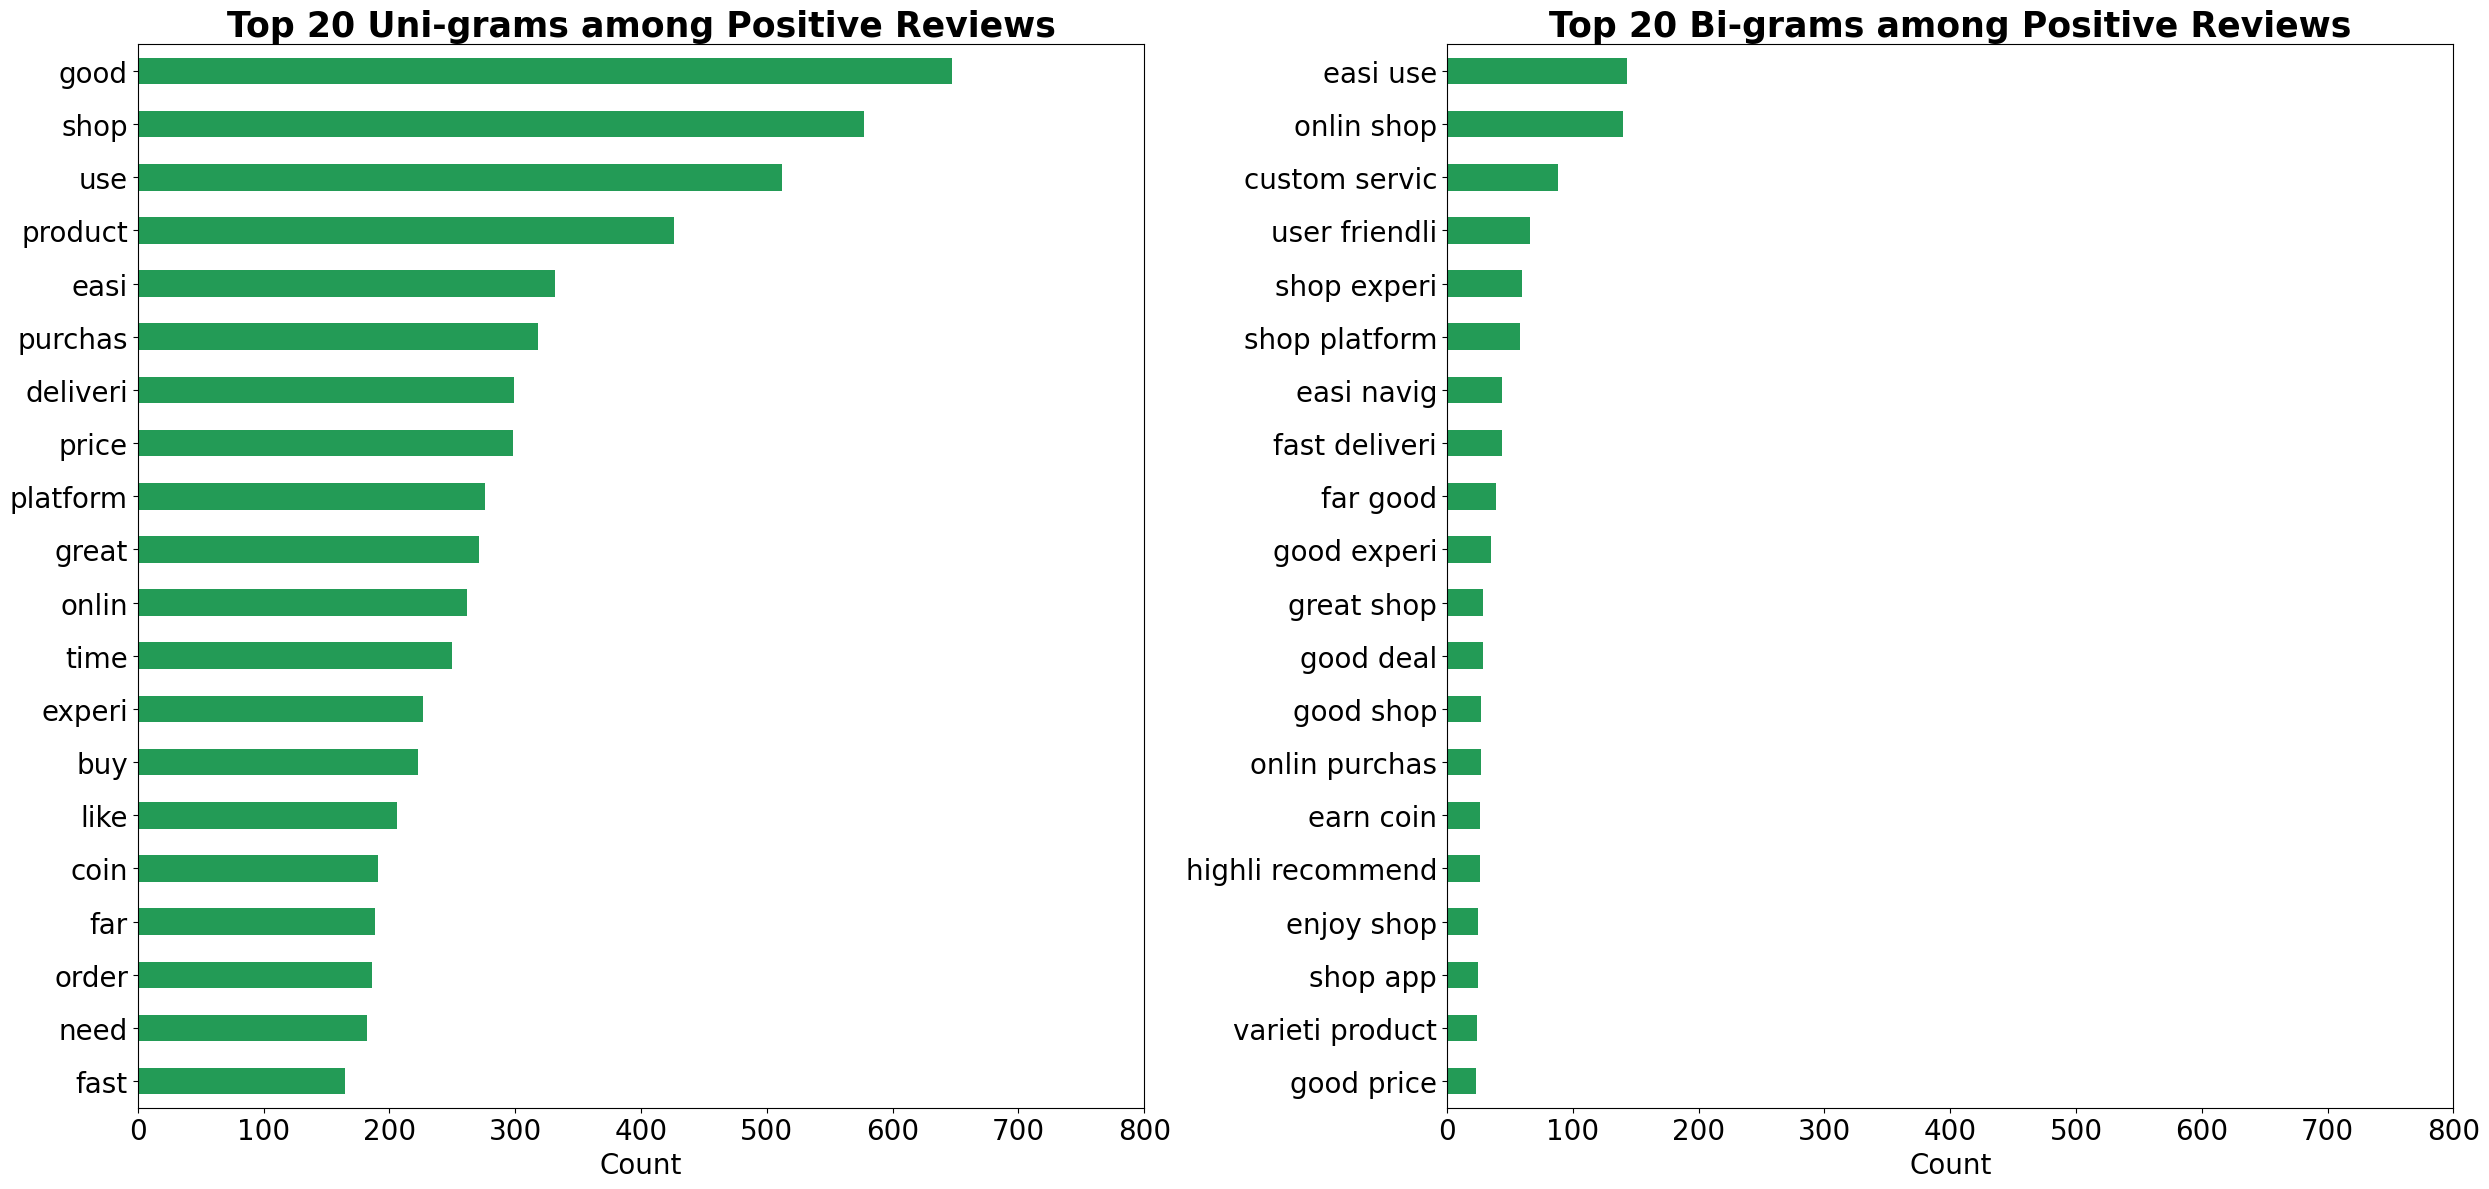

In [68]:
# Plot the uni-grams and bi-grams for positive reviews
barplot_cvec(target=0,
             titles=['Top 20 Uni-grams among Positive Reviews','Top 20 Bi-grams among Positive Reviews'], 
             color='#239B56',
             xlimit=(0,800))

**'Good', 'shop' and 'easi'** are the top 3 most frequently seen uni-grams in positive reviews. The bi-grams give us some context to the word 'easi', where it probably refers to an 'easy to use online shopping platform'.  

In [69]:
# Showing some of the positive reviews with the word 'good'
train[(train['target']==0) & (train['content_stem'].str.contains('good'))][['content','score']].head()

,content,score
0,"Good platform. Like that it will ensure product is well received before releasing money to seller, else they will refund buyer.",5
2,Good wide variety of goods. Enjoy shopping with Shopee. Keep it up. Hope to have more better offer than Lazada or Q010.,4
16,Great app with many offers but beware of overseas purchase. Check the review and make sure the price is not too good to be true especially electronic accessories.,4
17,Good search options and able to narrow down with various search filters. Thanks you Shopee.,5
18,"Since GSS, ive been using shopee frequently compared to other shopping apps mostly due to the good deals and different features to let u gain coins for coin cashback discount. So far so good! (Well, the app do lag at times) Still, Its a good app to use on top of the other common shopping apps in the market as there are wide choices of things to buy. I see that sometimes they have ""lucky draw"" too. If you have superb good luck then you might win something.",5


In [70]:
# Showing some of the positive reviews with the word 'shop'
train[(train['target']==0) & (train['content_stem'].str.contains('shop'))][['content','score']].head()

,content,score
2,Good wide variety of goods. Enjoy shopping with Shopee. Keep it up. Hope to have more better offer than Lazada or Q010.,4
8,"My purchased product arrived soon, great! However, my free welcome package was not delivered and eventually be cancelled by Shoppe. I asked for compensation but no asnwer at all! Very lousy!",4
11,Taking online shopping to a completely different level. Highly recommend.,4
15,"My experience in Shopee has been nothing but enjoyable. The platform has provided an avenue for affordable shopping for variety of products! I feel there is no need to worry as Shopee team is generally very fast to respond. There was a case when there was a problem with the delivery of my parcel, and Shopee was very quick to provide the refund, hence I feel safe shopping in Shopee! The only improvement I wish to see is to be able to my view my liked products in the Shopee dekstop version.",5
18,"Since GSS, ive been using shopee frequently compared to other shopping apps mostly due to the good deals and different features to let u gain coins for coin cashback discount. So far so good! (Well, the app do lag at times) Still, Its a good app to use on top of the other common shopping apps in the market as there are wide choices of things to buy. I see that sometimes they have ""lucky draw"" too. If you have superb good luck then you might win something.",5


### VADER sentiment analysis

[VADER](http://comp.social.gatech.edu/papers/icwsm14.vader.hutto.pdf) is a lexicon-based sentiment analysis tool that is specifically attuned to social media sentiments. We will use VADER to generate polarity scores for each review.

In [71]:
# Instantiate the sentiment intensity analyzer
sia = SentimentIntensityAnalyzer()

In [72]:
# Print a negative review in the training set
print(train.loc[2524,'content'])

# VADER's polarity scores for the negative review
sia.polarity_scores(train.loc[2524,'content'])

A must have app, for online shopping. Can kind all kinds of things you need and most major retailers are also on this platform. Highly recommended!


{'neg': 0.0, 'neu': 0.806, 'pos': 0.194, 'compound': 0.6989}

The compound score is a metric that calculates the sum of all the lexicon ratings which have been normalized between -1 (extremely negative sentiment) and +1 (extremely positive sentiment). VADER returns a compound score of -0.7351 in the example above, suggesting that it does well in predicting negative sentiment here. This is likely a result of VADER's ability to identify sentiment based on emojis, in addition to words. As VADER works well with emojis, slangs and even punctuations, we will evaluate VADER's performance on raw text, rather than the pre-processed text.

In [73]:
# Create an empty list to append the polarity scores
sia_list = []

# Loop through the text in the training dataset and create a dictionary of the VADER scores
for text in train['content']:
    sia_dict = {}
    sia_dict['neg'] = sia.polarity_scores(text)['neg'] # Negative score
    sia_dict['neu'] = sia.polarity_scores(text)['neu'] # Neutral score
    sia_dict['pos'] = sia.polarity_scores(text)['pos'] # Positive scores
    sia_dict['compound'] = sia.polarity_scores(text)['compound'] # Compound scores
    sia_list.append(sia_dict) # Append the dictionary of scores to the sia_list

In [74]:
# Create a dataframe from the sia_list
sia_df = pd.DataFrame(sia_list)

In [75]:
# Include 'content' and 'target' in sia_df
sia_df['content'] = train['content']
sia_df['target'] = train['target']

In [76]:
# View first 5 rows of sia_df
sia_df.head()

,neg,neu,pos,compound,content,target
0,0.000,0.627,0.373,0.8442,"Good platform. Like that it will ensure product is well received before releasing money to seller, else they will refund buyer.",0
1,0.055,0.651,0.294,0.8481,"My first experience, excited and joyful as i get to buy things without travel and looking high and low... Reasonable price and fast delivery. Thank you will recommend more people.",0
2,0.000,0.596,0.404,0.9041,Good wide variety of goods. Enjoy shopping with Shopee. Keep it up. Hope to have more better offer than Lazada or Q010.,0
3,0.189,0.794,0.017,-0.9294,"Dishonest facebook marketing brought me here. Spams you with ads of cheap items but its just a dishonest trick. The low price touted refers to an option in the listing to buy some assessory related to the item not the item itself. The only way to know is to download, install, sign up, find listing, click options, input phone number, price finally revealed... cant even delete the account after because of a convenient ""server error"".",1
4,0.000,0.872,0.128,0.4767,"Convenient and easy to use, however coupons have extremely strict criterias and often than not is just a flower vase to make shopee seem affordable and generous but not entirely",1


In [77]:
# Create empty lists to append the accuracy score for each compound score threshold level
threshold = []
accuracy = []

# Loop through a range of compound scores from -1 to +1 and calculate the accuracy score for each compound score
for i in np.linspace(-1, 1, 1000):
    vader_prediction = sia_df['compound'].map(lambda x: 0 if x > i else 1)
    score = accuracy_score(sia_df['target'], vader_prediction)
    threshold.append(i)
    accuracy.append(score)

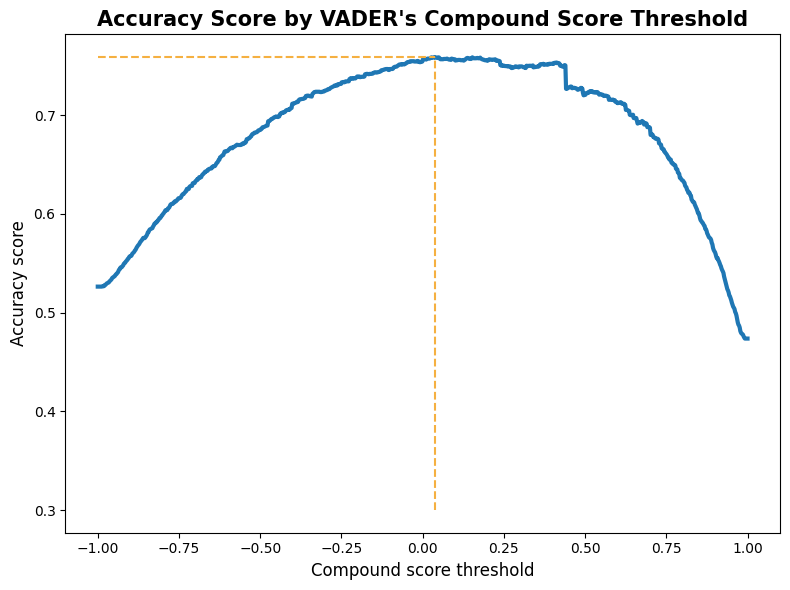

In [78]:
plt.figure(figsize=(8,6))

# Plots the accuracy score against compound score threshold
plt.plot(threshold, accuracy, linewidth=3)

# Plot a horizontal line that represents the best accuracy score achievable
plt.plot([-1,threshold[np.argmax(accuracy)]],[max(accuracy),max(accuracy)], linestyle='dashed', color='#F5B041')

# Plot a vertical line to show the corresponding compound score threshold for the best accuracy score
plt.plot([threshold[np.argmax(accuracy)],threshold[np.argmax(accuracy)]],[0.3,max(accuracy)], linestyle='dashed', color='#F5B041')

plt.title("Accuracy Score by VADER's Compound Score Threshold", size=15, weight='bold')
plt.ylabel('Accuracy score', size=12)
plt.xlabel('Compound score threshold', size=12)
plt.tight_layout()

In [79]:
print("VADER's best accuracy score: ", max(accuracy))
print('Compound score threshold: ', threshold[np.argmax(accuracy)])

VADER's best accuracy score:  0.7588815789473684
Compound score threshold:  0.03703703703703698


The chart above shows the respective accuracy score for every compound score threshold between -1 and 1. Given that we can shift the threshold to achieve the best accuracy score on our training set, if the compound score threshold was set at 0.175, VADER will be able to correctly classify 80% of the sentiments in our training data.

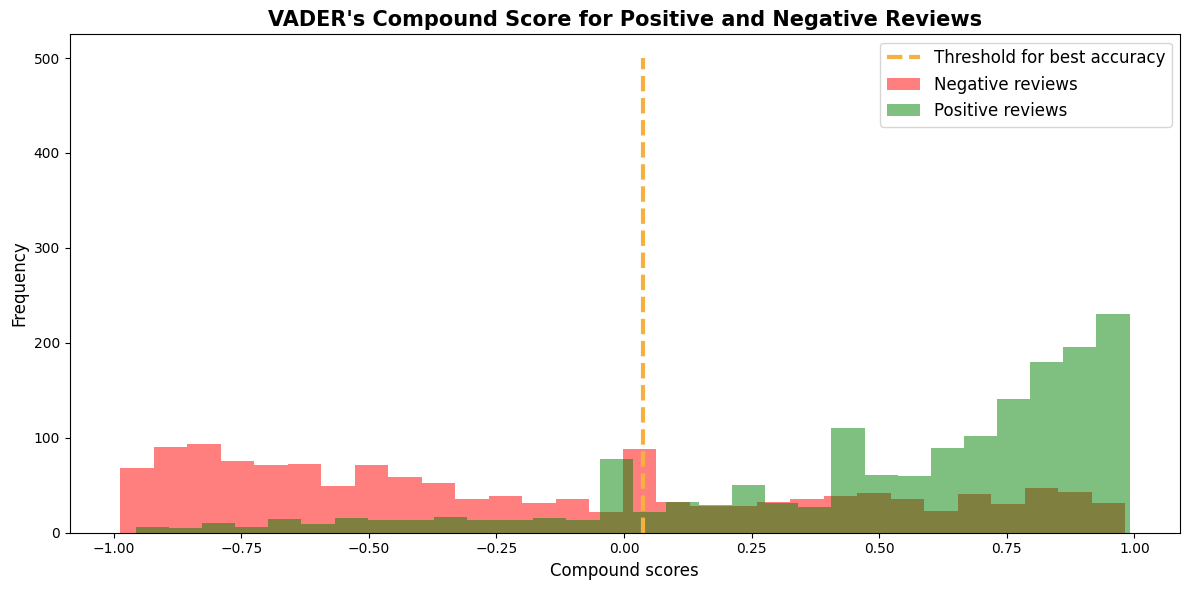

In [80]:
plt.figure(figsize=(12,6))

# Plot a histogram of the compound scores for negative reviews
sia_df[sia_df['target']==1]['compound'].hist(grid=False, color='red', alpha=0.5, bins=30)

# Plot a histogram of the compound scores for positive reviews
sia_df[sia_df['target']==0]['compound'].hist(grid=False, color='green', alpha=0.5, bins=30)

# Plot a vertical line to show the corresponding compound score threshold for the best accuracy score
plt.plot([threshold[np.argmax(accuracy)],threshold[np.argmax(accuracy)]],[0,500], linestyle='dashed', linewidth=3, color='#F5B041')

plt.title("VADER's Compound Score for Positive and Negative Reviews", size=15, weight='bold')
plt.legend(['Threshold for best accuracy','Negative reviews', 'Positive reviews'], fontsize=12)
plt.ylabel('Frequency', size=12)
plt.xlabel('Compound scores', size=12)
plt.tight_layout();

The chart above illustrates the distribution of the VADER compound scores for both the positive and negative reviews. In order to achieve the highest accuracy score of 80% on the training set, the compound score threshold will need to be adjusted to 0.175. However, as seen by the peak around the 0 score mark, this threshold will result in quite a few misclassifications of positive reviews. These positive reviews are likely to consist of rather neutral sentiment, thus leading to borderline scores of around 0.

In [81]:
# Prediction with compound threshold of 0.175
sia_df['vader_prediction'] = sia_df['compound'].map(lambda x: 0 if x > threshold[np.argmax(accuracy)] else 1)

In [82]:
# VADER's best accuracy score
accuracy_score(sia_df['target'], sia_df['vader_prediction'])

0.7588815789473684

In [83]:
# Confusion matrix
cm = confusion_matrix(sia_df['target'], sia_df['vader_prediction'])
cm_df = pd.DataFrame(cm, columns=['Predicted Positive Review','Predicted Negative Review'], index=['Actual Positive Review', 'Actual Negative Review'])
cm_df

,Predicted Positive Review,Predicted Negative Review
Actual Positive Review,1356,244
Actual Negative Review,489,951


In [84]:
# Classification report
print(classification_report(sia_df['target'], sia_df['vader_prediction']))

              precision    recall  f1-score   support

           0       0.73      0.85      0.79      1600
           1       0.80      0.66      0.72      1440

    accuracy                           0.76      3040
   macro avg       0.77      0.75      0.75      3040
weighted avg       0.76      0.76      0.76      3040



Given a compound score threshold of 0.175, VADER is able to correctly classify 80% of sentiments. As Shopee's product managers would also like to prioritise the identification of negative reviews so that they can fix immediate problems if necessary, achieving a decent recall rate is important. VADER is able to correctly classify 74% of actual negative reviews. It will be interesting to see if our machine learning models will be able to outperform VADER on accuracy and recall.

In [85]:
# Negative reviews that were predicted to be positive reviews
sia_df[(sia_df['target']==1) & (sia_df['vader_prediction']==0)].head(10)

,neg,neu,pos,compound,content,target,vader_prediction
4,0.000,0.872,0.128,0.4767,"Convenient and easy to use, however coupons have extremely strict criterias and often than not is just a flower vase to make shopee seem affordable and generous but not entirely",1,0
10,0.033,0.928,0.039,0.1027,"Do no USE Paynow to topup into their ShopeePay wallet. When you make a valid topup, they have issues and your wallet doesn't reflect the topup amount. They then will tell you they will need 3 working days to check and upon checking take another 5 working days to credit the topup amount. Some users waited for a week and still facing this issue.",1,0
13,0.107,0.711,0.182,0.4019,"Dropped my rating. Shopee App was doing great previously. Recently always having lag issues, even with frequent updates.",1,0
21,0.000,0.946,0.054,0.1655,Still waiting for my refund since 13 Jan 2023. Keep asking for information and then promise 7-14 days for refund. Process repeats but refund still not made to my acct.,1,0
27,0.000,0.925,0.075,0.7178,Was a very good shopping site. Recently their marketing kept sending discount voucher which they term non valid even upon receiving them. Why do they keep reminding me to use the voucher when its not valid when applied? Even today received encouragement to use before 23.59 via email. Upon application it is termed as non valid. When I called. They said campaign over. What a load of rubbish. Then they should not have sent the reminder.,1,0
32,0.062,0.822,0.116,0.2841,"Shoppe is bloated at 80MB n is getting more cluttered. When launched, it sucks lots of bandwidth 1Mbps. Browsing products drains battery fast as the phone gets hotter by the min!! Can have Dark Mode please?",1,0
34,0.072,0.868,0.061,0.3837,"Download the app but yet to use. See? Doesn't seem fair right? 90% of user reviews either don't address the product quality at all, or are rating the deliveries! Shopee is not doing much to change that. We should be given longer grace period to leave reviews, and should also be able to edit them anytime",1,0
46,0.027,0.771,0.201,0.8700,"I have multiple account that i never registered with shopee. I guess the shopee apps security not safe enough to protect the users. I try to contact the customer service through email but still my account keep changing with other username that i never registered. For shopee, kindly help me to settle this matters.",1,0
53,0.111,0.681,0.209,0.3182,"Nice shopping app, except that I dislike using ShopeePay which is the only accepted payment method to use vouchers..",1,0
55,0.085,0.732,0.184,0.8095,"I can no longer collect coins from daily check in, what happened??? I have already updated the app but still the same... And it's very laggy when browsing through products. This used to be my favorite online shopping platform but now it's getting too frustrating to enjoy. Please update your app sooner...",1,0


In [86]:
# Positive reviews that were predicted to be negative reviews
sia_df[(sia_df['target']==0) & (sia_df['vader_prediction']==1)].head(10)

,neg,neu,pos,compound,content,target,vader_prediction
7,0.114,0.886,0.000,-0.4111,"Bit messy to navigate initially, and very annoying to have small game popups and reminders within the app when you're browsing on home page. But otherwise, haven't had any technical issues.",0,1
8,0.246,0.594,0.159,-0.6874,"My purchased product arrived soon, great! However, my free welcome package was not delivered and eventually be cancelled by Shoppe. I asked for compensation but no asnwer at all! Very lousy!",0,1
29,0.000,1.000,0.000,0.0000,"I can't view live sale for a few channels. I have reinstalled the app, yet it's still the same.",0,1
68,0.270,0.730,0.000,-0.7500,"Edited 1 🌟 lower. Pet game is always stuck at loading 99%. I kept log in log out, uninstall and install. Frustrating!",0,1
94,0.138,0.695,0.167,0.0065,Not bad app... But some of the sellers did not give the items that I ordered... There are good and bad about the sellers In this app..,0,1
97,0.093,0.847,0.059,-0.6335,"I find that some of the items on shopee are really value for money, but you have to choose wisely. Only issue I have is with the delivery company who deliver the items to the home. Really the worst deliver company i experienced, maybe because they are cheap or paid low for each delivery. They simply just place the item at your door step regardless if anyone is at home to receive. It's due to the delivery company which I place 4 star.",0,1
152,0.149,0.721,0.129,-0.2021,Everything good just that the cannot earn any coins. I think got bug. I am not awarded any coins even though the app states that I checked in. Please fix it. So frustrating.,0,1
161,0.234,0.694,0.072,-0.6808,I like to shop at Shopee. However I feel that Shopee should review the sellers' credibility. I have to reject products as sellers gave misleading specifications. It's annoying.,0,1
163,0.241,0.541,0.219,0.0258,I enjoyed online shopping. Shoppee ease my boredom. Email enquires set up currently has no audit trail which caused a lot of confusions and frustrated. This could be improved.,0,1
181,0.123,0.776,0.100,-0.1280,Recently app having problem loading gallery for photos and videos attachment. It happens during leaving of review and chat.,0,1


## Save clean datasets for modeling

In [87]:
# Keep only the columns that we need for modeling and interpretation
train = train[['content','content_stem','score','target']]
test = test[['content','content_stem','score','target']]

In [88]:
# Save clean training set
train.to_csv('../data/clean_train2.csv', index=False)

In [89]:
# Save clean test set
test.to_csv('../data/clean_test2.csv', index=False)